# Analyze Stock Portfolio for Risks and Returns

## Problem Statement

Asset allocation is the most important decision that any investor needs to face. They need to decide how to spread their total capital over certain assets (in this case, stocks). When considering the allocation, the investor wants to balance the risk and the potential reward. At the same time, the allocation depends on factors such as individual goals, risk tolerance, and the investment horizon.

The key framework used in asset allocation is the **Modern Portfolio Theory (MPT)**, which was introduced by the Nobel Prize winner Harry Markowitz. MPT describes how investors can construct portfolios to maximize their expected returns for a given level of risk or, conversely, minimize risk for a given level of expected return. The mathematical framework used to achieve this is called mean-variance optimization.

The main insight from MPT is that investors should not evaluate an asset’s performance alone. Instead, they should evaluate how it would impact the performance of a portfolio of assets. Another important takeaway is the concept of diversification, which means that owning different kinds of assets reduces risk. That is because the loss or gain of a particular security has less impact on the overall portfolio’s performance.

**Your task**

In the dynamic realm of finance, data scientists/analysts are often tasked with finding optimal investment strategies. Imagine you're one such analyst, and you were asked to build an effective portfolio comprising FAANG stocks – Facebook (Meta), Apple, Amazon, Netflix, and Google. Your goal is to maximize returns while mitigating risk.

In this project, you are tasked to find the optimal allocation to the FAANG stocks based on historical stock price data spanning the years 2020-2023. The dataset is stored in the `faang_stocks.csv` file. For each trading day, it contains the close prices of the five tech companies.


## Theoretical Background

* Arithmetic Returns: The percentage change in a stock's price over a period.

  * Equation: $$R = \frac{P_1 - P_0}{P_0}$$

   R represents the return.
   $P_1$ is the price at the end of the period.
   $P_0$ is the price at the beginning of the period.

* Portfolio Returns: The weighted average of the returns of all the individual stocks in a portfolio.

  * Equation: $$R_p = \sum_{i=1}^{N} w_i R_i$$

   $R_p$ is the portfolio return.
   $w_i$ is the weight (or proportion) of asset i in the portfolio.
   $R_i$ is the return of asset i.
   $N$ is the total number of assets in the portfolio.

* Sharpe Ratio: A measure of risk-adjusted return, showing how much extra return you get for each unit of risk.

  * Equation: $$S = \frac{R_p - R_f}{\sigma_p}$$

   S is the Sharpe Ratio.
   $R_p$  is the portfolio's expected return.
   $R_f$ is the risk-free rate of return.
   $σ_p$ is the standard deviation of the portfolio's excess return.

* Risk-Free Rate: The return on an investment with zero risk, often represented by the yield on government bonds.

* Standard Deviation $(σ_p)$: A measure of how much the portfolio's returns vary from the average return; it represents portfolio volatility or risk.

* Covariance Matrix: A table that shows how the returns of each pair of stocks in a portfolio move together.

* Mean-Variance Optimization: A method for building a portfolio that aims to get the highest possible return for a given level of risk.

* Efficient Frontier: A set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return.

* Minimum Volatility Portfolio: The portfolio on the Efficient Frontier with the lowest possible risk.

* Maximum Sharpe Ratio Portfolio: The portfolio on the Efficient Frontier that gives the best risk-adjusted return.

* Annualization: The process of converting returns or volatility from a shorter period (like daily) to an annual rate by multiplying by the number of trading days, often 252.

## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
# Setting the plotting style to be colorblind-friendly
plt.style.use("seaborn-colorblind")

In [ ]:
# Loading data
stock_prices_df = pd.read_csv("faang_stocks.csv", index_col="Date")

# Changing the index to a datetime type allows for easier filtering and plotting.
stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
stock_prices_df

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-02,75.09,94.90,68.43,209.78,329.81
2020-01-03,74.36,93.75,68.08,208.67,325.90
2020-01-06,74.95,95.14,69.89,212.60,335.83
2020-01-07,74.60,95.34,69.76,213.06,330.75
2020-01-08,75.80,94.60,70.25,215.22,339.26
...,...,...,...,...,...
2023-12-22,193.60,153.42,141.49,353.39,486.76
2023-12-26,193.05,153.41,141.52,354.83,491.19
2023-12-27,193.15,153.34,140.37,357.83,491.79


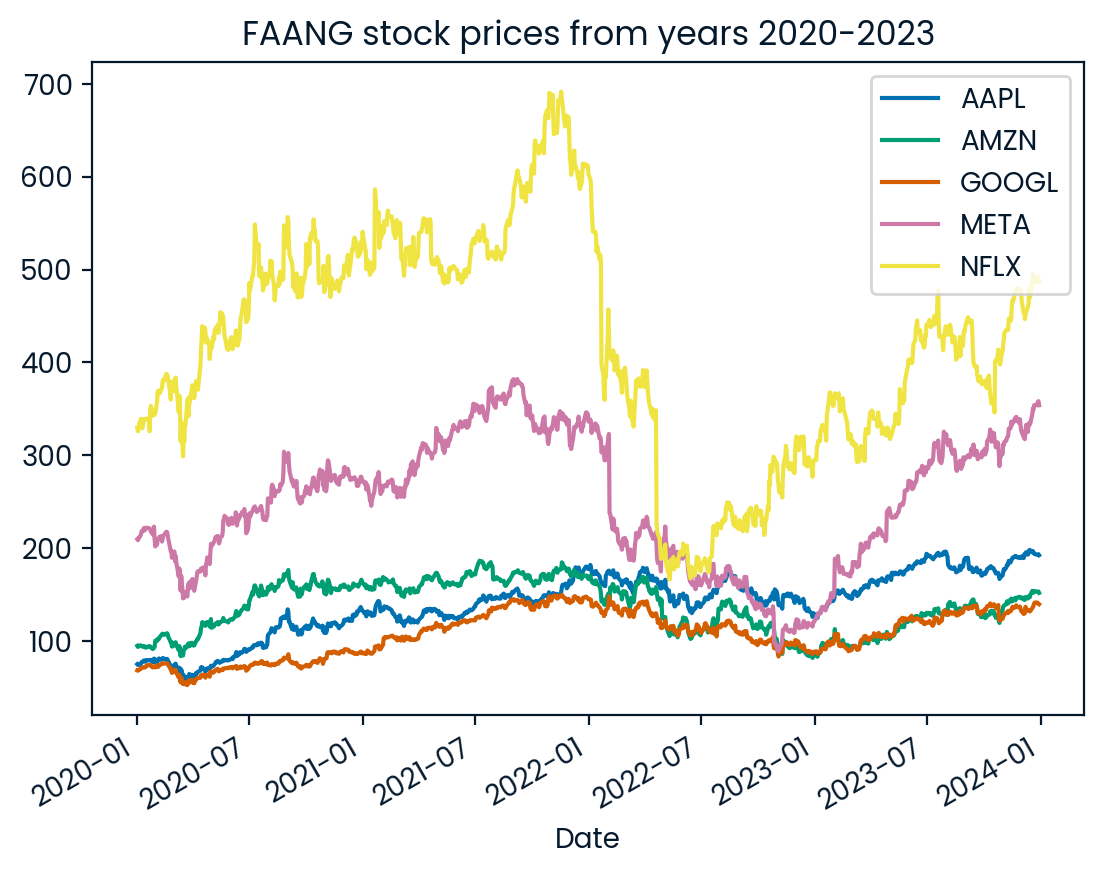

In [ ]:
# Plotting the stock prices
stock_prices_df.plot(title="FAANG stock prices from years 2020-2023");

## Evaluate the benchmark (equally-weighted) portfolio

In [ ]:
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1006 non-null   float64
 1   AMZN    1006 non-null   float64
 2   GOOGL   1006 non-null   float64
 3   META    1006 non-null   float64
 4   NFLX    1006 non-null   float64
dtypes: float64(5)
memory usage: 79.4 KB


In [ ]:
stock_prices_df.describe()

,AAPL,AMZN,GOOGL,META,NFLX
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,140.808101,137.216163,107.870219,249.362266,420.203350
std,33.313922,27.468851,25.114959,71.002682,120.829682
min,56.090000,81.820000,52.710000,88.910000,166.370000
25%,123.592500,114.307500,88.027500,193.565000,337.590000
50%,145.860000,140.585000,109.885000,259.915000,428.305000
75%,166.215000,161.190000,130.250000,310.547500,509.102500
max,198.110000,186.570000,149.840000,382.180000,691.690000


In [ ]:
stock_prices_df.isnull().sum()

AAPL     0
AMZN     0
GOOGL    0
META     0
NFLX     0
dtype: int64

### Calculate arithmetic returns from stock prices

In [ ]:
# Calculate arithmetic (simple) returns from stock prices
stock_returns_df = stock_prices_df.pct_change().dropna()
stock_returns_df

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-03,-0.009722,-0.012118,-0.005115,-0.005291,-0.011855
2020-01-06,0.007934,0.014827,0.026586,0.018834,0.030469
2020-01-07,-0.004670,0.002102,-0.001860,0.002164,-0.015127
2020-01-08,0.016086,-0.007762,0.007024,0.010138,0.025729
2020-01-09,0.021240,0.004757,0.010534,0.014311,-0.010611
...,...,...,...,...,...
2023-12-22,-0.005548,-0.002730,0.007620,-0.001977,-0.009866
2023-12-26,-0.002841,-0.000065,0.000212,0.004075,0.009101
2023-12-27,0.000518,-0.000456,-0.008126,0.008455,0.001222


### Set the portfolio weights

In [ ]:
# Set equal portfolio weights for the 5 assets
portfolio_weights = [0.2] * 5
portfolio_weights

[0.2, 0.2, 0.2, 0.2, 0.2]

### Calculate portfolio returns

In [ ]:
# Calculate portfolio returns by multiplying stock returns with portfolio weights
portfolio_returns = stock_returns_df.dot(portfolio_weights)
portfolio_returns

Date
2020-01-03   -0.008820
2020-01-06    0.019730
2020-01-07   -0.003478
2020-01-08    0.010243
2020-01-09    0.008046
                ...   
2023-12-22   -0.002500
2023-12-26    0.002096
2023-12-27    0.000322
2023-12-28    0.000051
2023-12-29   -0.007646
Length: 1005, dtype: float64

### Calculate the expected return and the Sharpe ratio

In [ ]:
# Calculate the expected return (mean of portfolio returns)
benchmark_exp_return = portfolio_returns.mean()

# Calculate the standard deviation of portfolio returns
portfolio_std = portfolio_returns.std()

In [ ]:
# Calculate the Sharpe ratio (assuming risk-free rate is 0)
#benchmark_sharpe_ratio = benchmark_exp_return / portfolio_std

benchmark_sharpe_ratio = (
    portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
)

In [ ]:
benchmark_exp_return, benchmark_sharpe_ratio

(0.0009366970530650012, 0.7221868020795013)

0.0009 is the average daily return of the equally-weighted portfolio.

Approximately 0.72 is the annualized Sharpe Ratio of the equally-weighted portfolio. This measures the portfolio's risk-adjusted return, with a higher value indicating better performance for the risk taken.

## Finding the minimum volatility portfolio

### Calculate the average returns and the covariance matrix, both annualized

In [ ]:
# Calculate the average daily returns for each stock
avg_returns = stock_returns_df.mean() * 252

# Calculate the covariance matrix of daily returns and annualize it
cov_mat = stock_returns_df.cov() * 252

avg_returns, cov_mat

(AAPL     0.292454
 AMZN     0.188956
 GOOGL    0.235250
 META     0.242660
 NFLX     0.220919
 dtype: float64,
            AAPL      AMZN     GOOGL      META      NFLX
 AAPL   0.112683  0.078926  0.077773  0.095367  0.077774
 AMZN   0.078926  0.142040  0.083945  0.108089  0.101851
 GOOGL  0.077773  0.083945  0.112423  0.106969  0.076233
 META   0.095367  0.108089  0.106969  0.218838  0.116967
 NFLX   0.077774  0.101851  0.076233  0.116967  0.237020)

### Find the Efficient Frontier

In [ ]:
# Instantiate the EfficientFrontier object with expected returns and covariance matrix
ef = EfficientFrontier(avg_returns, cov_mat)
ef

### Find the portfolio that minimizes volatility

In [ ]:
# Weights that minimize volatility
min_vol_weights = ef.min_volatility()
mv_portfolio = pd.Series(min_vol_weights, index=avg_returns.index)
mv_portfolio

AAPL     0.398420
AMZN     0.149108
GOOGL    0.382898
META     0.000000
NFLX     0.069574
dtype: float64

### Find the volatility of the portfolio

In [ ]:
# Extract the volatility of the minimum volatility portfolio
mv_portfolio_vol = ef.portfolio_performance()[1]
mv_portfolio_vol

0.3030736711547463

Volatility is a measure of risk, specifically how much the portfolio's returns are expected to fluctuate around its average return. An annualized volatility of approximately 0.30 means that the portfolio's returns are expected to vary by about 30.3% over a year. A lower volatility generally indicates a less risky portfolio.

## Find the portfolio that maximizes the Sharpe ratio

### Calculate the expected returns and the covariance matrix

In [ ]:
# Calculate expected returns (arithmetic mean, no compounding)
avg_returns = expected_returns.mean_historical_return(stock_prices_df, compounding=False)

# Calculate the sample covariance matrix of returns
cov_mat = risk_models.sample_cov(stock_prices_df)

### Find the Efficient Frontier

In [ ]:
# Instantiate the EfficientFrontier object with expected returns and covariance matrix
ef = EfficientFrontier(avg_returns, cov_mat)
ef

### Find the portfolio that maximizes the Sharpe ratio

In [ ]:
# Find the portfolio weights that maximize the Sharpe ratio
max_sharpe_weights = ef.max_sharpe(risk_free_rate=0)

# Store the weights in a pandas Series with tickers as the index
ms_portfolio = pd.Series(max_sharpe_weights, index=avg_returns.index)
ms_portfolio

AAPL     0.787440
AMZN     0.000000
GOOGL    0.199698
META     0.000000
NFLX     0.012861
dtype: float64

### Get the Sharpe ratio of the portfolio

In [ ]:
# Get the Sharpe ratio of the optimized portfolio
ms_portfolio_sharpe = ef.portfolio_performance(risk_free_rate=0)[2]
ms_portfolio_sharpe

0.8821809421501468

The value 0.8821809421501468 signifies the annualized Sharpe Ratio of the portfolio that maximizes the Sharpe Ratio.

This is a key metric from Modern Portfolio Theory and represents the risk-adjusted return of this specific portfolio. Compared to the equally-weighted portfolio's Sharpe Ratio of approximately 0.72, this optimized portfolio has a higher Sharpe Ratio (approximately 0.88). This indicates that, for the level of risk taken, this portfolio is expected to provide a better return than the equally-weighted portfolio.